In [13]:
%load_ext autoreload
%autoreload 2

import os
import sys
import copy
import pickle
import numpy as np
import scipy as sci
import pandas as pd
from astropy.io import fits
from tqdm import tqdm
import matplotlib as mpl
from astropy import units 
import ChiantiPy.core as ch
from astropy.io import ascii
import matplotlib.pyplot as plt
from lightkurve import LightCurve
from astropy.table import Table
from astropy.table import Column
import astropy.constants as const
from dynesty import utils as dyfunc
from dynesty.plotting import _quantile
from scipy.interpolate import interp1d
from dynesty import DynamicNestedSampler

from lmfit.models import Model
from specutils import Spectrum1D, SpectralRegion
from specutils.analysis import line_flux, equivalent_width
from astropy.nddata import StdDevUncertainty, NDUncertainty

COLOR = 'k'
plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size']  = 10 #12
plt.rcParams['ytick.major.size']  = 10 #12

plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size']  = 6
plt.rcParams['ytick.minor.size']  = 6

plt.rcParams['axes.linewidth'] = 3

plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
#plt.rcParams['axes.spines.top'] = False
#plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'



distance = (9.72*units.pc).to(units.cm)
distanceErr = (0.004625*units.pc).to(units.cm)
radius   = (0.75*units.Rsun).to(units.cm)
radiusErr= (0.03*units.Rsun).to(units.cm)

surface_scaling = ((distance/radius)**2).value

parula = np.load('/Users/arcticfox/parula_colors.npy', allow_pickle=True)

sys.path.append('/Users/arcticfox/Documents/GitHub/cos_flares/src/')
from dem_modeling import ChiantiSetup, DEMModeling, setup_linelist
from utils import *
from cos_flares import FlaresWithCOS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## The Line Table Input

This table must have the following columns:
- Ion : ion name.
- wave_obs : observed center wavelength (Wavelength = center in vacuum).
- wmin : lower/bluer wavelength end of the line.
- wmax : upper/redder wavelength end of the line.
- quality : an array of 0s and 1s indicating whether to use that line or not.
- X-ray : an array of 0s and 1s indicating whether the ion is in the X-ray or not

In [4]:
line_table = Table.read('/Users/arcticfox/Documents/AUMic/aumic_linelist.csv',
                        format='csv', comment='#')
logT_range=[4,8]

## HST/COS specific setup to get wavelength & spectrum

In [5]:
def load_data(path):
    wavelength, flux, err = load_binned_data(os.path.join(path,'interp_between_1.npy'))

    times = np.load(os.path.join(path,'times.npy'))
    orbits = np.load(os.path.join(path,'orbits.npy'))

    wavelength = np.full(flux.shape, wavelength)
    return wavelength, flux, err, times, orbits

w20, f20, e20, t20, o20 = load_data(path='/Users/arcticfox/Documents/AUMic/30s/reduced')
w30, f30, e30, t30, o30 = load_data(path='/Users/arcticfox/Documents/AUMic/30s/reduced2')

_, flare_orbits, flare_mask = np.load('/Users/arcticfox/Documents/AUMic/flare_mask2.npy',
                                      allow_pickle=True)

In [6]:
fwc = FlaresWithCOS(wavelength=np.append(w20, w30, axis=0), 
                    flux=np.append(f20, f30, axis=0),
                    flux_err=np.append(e20, e30, axis=0), 
                    time=np.append(t20, t30)-t20[0], 
                    orbit=np.append(o20, o30+5))
line_table = Table.read('/Users/arcticfox/Documents/AUMic/aumic_linelist.csv', format='csv')

In [7]:
mq = np.nansum(flare_mask,axis=0)==0
mean_quiescent = np.nanmean(fwc.flux[mq],axis=0)
mean_quiexcent_err = np.sqrt(np.nansum(fwc.flux_err[mq]**2, axis=0))/len(fwc.flux_err[mq])

mf = flare_mask[1]>0
mean_flare = np.nanmean(fwc.flux[mf],axis=0)
mean_flare_err = np.sqrt(np.nansum(fwc.flux_err[mf]**2, axis=0))/len(fwc.flux_err[mf])

## Creating the line list dictionary

In [135]:
sys.path.append('/Users/arcticfox/Documents/GitHub/cos_flares/src/')
from dem_modeling import ChiantiSetup, DEMModeling, setup_linelist
from utils import *
from cos_flares import FlaresWithCOS

In [136]:
aumic_linelist_q = setup_linelist(fwc.wavelength[0], # wavelength array
                                    mean_quiescent,    # spectrum
                                    mean_quiexcent_err,# spectrum error
                                    line_table,        # table of ions
                                    distance, distanceErr, # distance & error
                                    radius, radiusErr) # stellar radius & error
print('----')
aumic_linelist_f = setup_linelist(fwc.wavelength[0], # wavelength array
                                    mean_flare,    # spectrum
                                    mean_flare_err,# spectrum error
                                    line_table,        # table of ions
                                    distance, distanceErr, # distance & error
                                    radius, radiusErr) # stellar radius & error

/Users/arcticfox/Documents/GitHub/cos_flares/src/dem_modeling.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  linelist[ak][s] = np.array(linelist[ak][s])


----


In [137]:
xmm = fits.open('xmm_averaged.FTZ')
xmm_wavelength = xmm[1].data['CHANNEL']
xmm_spectra = xmm[1].data['FLUX']
xmm_err = xmm[1].data['ERROR']

area = Table.read('effective_area.csv')
E = ((const.h*const.c)/(xmm_wavelength*units.AA)).to(units.keV)

q = (E.value>area['E_kev'][0]) & (E.value<area['E_kev'][-1])
sub = E[q]
interp_area = interp1d(area['E_kev'], area['Ae'])

Texp = (4400*28)*units.s
Ae=100*units.cm**2
xmm_spectra = (((xmm_spectra[q]*units.erg)/Ae/Texp)).value
xmm_err = (xmm_err[q]/Ae/Texp).value

/Users/arcticfox/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


(5.0, 20.0)

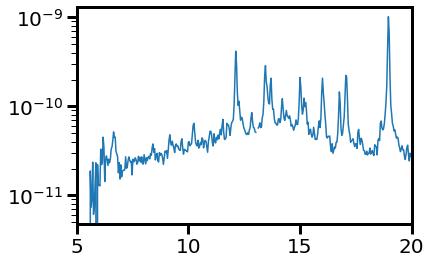

In [138]:
plt.plot(xmm_wavelength[q], xmm_spectra)
plt.yscale('log')
plt.xlim(5,20)

In [139]:
aumic_linelist_xq = setup_linelist(xmm_wavelength[q], # wavelength array
                                   xmm_spectra,    # spectrum
                                   xmm_err,# spectrum error
                                    line_table,        # table of ions
                                    distance, distanceErr, # distance & error
                                    radius, radiusErr, # stellar radius & error
                                   xray=True, scaling=1e-12)
print('----')
aumic_linelist_xf = setup_linelist(xmm_wavelength[q], # wavelength array
                                   xmm_spectra*5,    # spectrum
                                   xmm_err,# spectrum error
                                    line_table,        # table of ions
                                    distance, distanceErr, # distance & error
                                    radius, radiusErr, # stellar radius & error
                                   xray=True, scaling=1e-12)

Couldn't get amplitude error for:  Si XXII  at  6.68


/Users/arcticfox/Documents/GitHub/cos_flares/src/dem_modeling.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  linelist[ak][s] = np.array(linelist[ak][s])


----
Couldn't get amplitude error for:  Si XXII  at  6.68


In [140]:
aumic_linelist_f.update(aumic_linelist_xf)
aumic_linelist_q.update(aumic_linelist_xq)

In [141]:
pickle.dump(aumic_linelist_q, open('aumic_linelist_q.pkl','wb'))
pickle.dump(aumic_linelist_f, open('aumic_linelist_f.pkl','wb'))

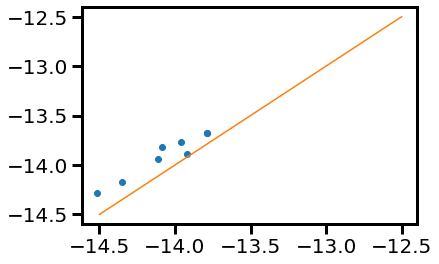

In [142]:
plt.plot(np.log10(aumic_linelist_q['SiII']['amp']), 
         np.log10(aumic_linelist_f['SiII']['amp']), 'o')
plt.plot(np.linspace(-14.5, -12.5, 10), np.linspace(-14.5, -12.5, 10))

In [143]:
cs_q = ChiantiSetup(linelist=aumic_linelist_f,
                    logT_range=logT_range,
                    wave_range=[1,3200], setup=False,
                    abundance='sun_coronal_2012_schmelz_ext')

for k in list(aumic_linelist_q.keys()):
    chiname = cs_q.create_chiname(k)
    aumic_linelist_q[k]['CHIname'] = chiname
    aumic_linelist_f[k]['CHIname'] = chiname

## Setting up files from Chianti

In [ ]:
cs_q = ChiantiSetup(linelist=aumic_linelist_q,
                    logT_range=logT_range,
                    wave_range=[1,3200], setup=True,
                    abundance='sun_coronal_2012_schmelz_ext')

cs_q.emissivity_functions()
cs_q.get_all_ions(top=30)

pickle.dump(cs_q.G_T, open('aumic_q_G_T_ext.pkl','wb'))
pickle.dump(cs_q.linelist, open('aumic_q_linelist_updated_ext.pkl', 'wb'))

In [ ]:
cs_f = ChiantiSetup(linelist=aumic_linelist_f,
                    logT_range=logT_range,
                    wave_range=[1,3200], setup=True,
                    abundance='sun_coronal_2012_schmelz_ext')
cs_f.emissivity_functions()
cs_f.get_all_ions(top=30)

pickle.dump(cs_f.G_T, open('aumic_f_G_T_ext.pkl','wb'))
pickle.dump(cs_f.linelist, open('aumic_f_linelist_updated_ext.pkl', 'wb'))

## DEM Modeling

In [144]:
aumic_linelist_q_ext = pd.read_pickle(r'aumic_q_linelist_updated_ext.pkl')
#aumic_linelist_q = pd.read_pickle(r'aumic_q_linelist_updated.pkl')

#aumic_linelist_q.pop('H2')
#aumic_linelist_q.pop('SiI')
#aumic_linelist_q.pop('EUV')

G_T_q_ext = pd.read_pickle(r'aumic_q_G_T_ext.pkl')
G_T_q = pd.read_pickle(r'aumic_q_G_T.pkl')

In [145]:
aumic_linelist_f_ext = pd.read_pickle(r'aumic_f_linelist_updated_ext.pkl')
#aumic_linelist_f = pd.read_pickle(r'aumic_f_linelist_updated.pkl')

#aumic_linelist_f.pop('H2')
#aumic_linelist_f.pop('SiI')
#aumic_linelist_f.pop('EUV')

G_T_f_ext = pd.read_pickle(r'aumic_f_G_T_ext.pkl')
G_T_f = pd.read_pickle(r'aumic_f_G_T.pkl')

In [146]:
def split_dictionary(lines):
    newdict = {}
    
    for k in list(lines.keys()):
        try:
            subkeys = list(lines[k].keys())
            for i in range(len(lines[k]['centers'])):
                newk = '{0}_{1:02d}'.format(k, i)
                subdict = {}
                for sk in subkeys:
                    if type(lines[k][sk]) == list or type(lines[k][sk])==np.ndarray:
                        subdict[sk] = np.array([lines[k][sk][i]])
                        if sk=='Fline' or sk=='log10SFline':
                            subdict[sk] = np.array([lines[k][sk][i]])+1.0
                    else:
                        subdict[sk] = lines[k][sk]
                newdict[newk] = subdict
        except:
            pass
    return newdict

In [147]:
def run_demmodeling(lines, gt, letter='q', extension=''):
    dem = DEMModeling(linelist=lines,
                      G_T=gt,
                      logT_range=logT_range)
    dem.create_DEM(quick_plot=False, 
                   specified_lines=list(dem.linelist.keys()),
                   resample=True,
                   results_filename='DEMresults_{0}{1}'.format(letter, extension),
                   grid_filename='DEMgrid_{0}{1}'.format(letter, extension))
    return dem

### Testing by removing the outliers

In [148]:
aumic_linelist_q.pop('OVI')
aumic_linelist_q.pop('SV')
aumic_linelist_q.pop('NVI')
dem_q = run_demmodeling(aumic_linelist_q, G_T_q)

H2 1163.73275784542
H2 1338.48503426151
H2 1342.21893072226
si_1 1255.26532167998
si_1 1258.77633674347
si_22 6.68


34573it [05:03, 113.96it/s, batch: 8 | bound: 266 | nc: 1 | ncall: 216052 | eff(%): 16.002 | loglstar: -1939.304 < -1930.836 < -1932.995 | logz: -1963.540 +/-    nan | stop:  0.910]       


In [149]:
aumic_linelist_f.pop('OVI')
aumic_linelist_f.pop('SV')
aumic_linelist_f.pop('NVI')
dem_f = run_demmodeling(aumic_linelist_f, G_T_f, letter='f')

H2 1163.73275784542
H2 1338.48503426151
H2 1342.21893072226
si_1 1255.26532167998
si_1 1258.77633674347
si_22 6.68


29277it [03:27, 141.30it/s, batch: 6 | bound: 242 | nc: 2 | ncall: 200458 | eff(%): 14.605 | loglstar: -1844.155 < -1836.170 < -1837.904 | logz: -1868.872 +/-    nan | stop:  0.959]        


In [150]:
dem_q.estimate_EUV_from_DEM()
dem_f.estimate_EUV_from_DEM()

/Users/arcticfox/Documents/GitHub/cos_flares/src/dem_modeling.py:702: RuntimeWarning: divide by zero encountered in log10
  localdict[ion]['log10SFline'].append(np.log10(I_ul*np.pi))
/Users/arcticfox/Documents/GitHub/cos_flares/src/dem_modeling.py:705: RuntimeWarning: divide by zero encountered in log10
  localdict[ion]['log10SFline'].append(np.log10(I_ul*np.pi))


In [62]:
pickle.dump(dem_q.linelist, open('aumic_q_dem_models.pkl','wb'))
pickle.dump(dem_f.linelist, open('aumic_f_dem_models.pkl','wb'))

In [25]:
resf = pd.read_pickle(r'DEMgrid_f.pkl')
resq = pd.read_pickle(r'DEMgrid_q.pkl')

for i in range(len(resq)):
    plt.plot(resf[i], 'darkorange', alpha=0.1)
    plt.plot(resq[i], 'navy', alpha=0.1)

In [151]:
def plot_dem(quies, flare):

    fig,ax = plt.subplots(figsize=(14,4))
    for line in list(flare.keys())[:-1]:
        for i, w in enumerate(flare[line]['centers']):
            try:
                plt.errorbar(np.log10(flare[line]['peakFormTemp'][i]), 
                             np.log10(flare[line]['avgDEM'][i]), 
                             #yerr=flare[line]['avgDEMErr'][i]/flare[line]['avgDEM'][i]/np.log(10), 
                             fmt='o', color=parula[200])
                plt.errorbar(np.log10(quies[line]['peakFormTemp'][i]), 
                             np.log10(quies[line]['avgDEM'][i]), 
                             #yerr=quies[line]['avgDEMErr'][i]/quies[line]['avgDEM'][i]/np.log(10), 
                             fmt='o', color=parula[0])
                
                if ((np.log10(flare[line]['peakFormTemp'][i])>6) and 
                    (np.log10(flare[line]['avgDEM'][i])>28)):
                    print(line, quies[line]['centers'][i])
                if np.log10(flare[line]['avgDEM'][i])>35:
                    print(line, quies[line]['centers'][i])

            except:
                print(line)
                pass
            
    line, i = 'CI', 0
    plt.errorbar(np.log10(flare[line]['peakFormTemp'][i]), 
                             np.log10(flare[line]['avgDEM'][i]), 
                             #yerr=flare[line]['avgDEMErr'][i]/flare[line]['avgDEM'][i]/np.log(10), 
                             fmt='o', color=parula[200], label='DEMs, Flare')
    plt.errorbar(np.log10(quies[line]['peakFormTemp'][i]), 
                 np.log10(quies[line]['avgDEM'][i]), 
                 #yerr=quies[line]['avgDEMErr'][i]/quies[line]['avgDEM'][i]/np.log(10), 
                 fmt='o', color=parula[0], label='DEMs, Quiescent')
            
        
    plt.plot(flare['EUV']['DEMUV']['Chebyshev']['Trange'], 
             flare['EUV']['DEMUV']['Chebyshev']['Fit'][1], 
             lw=3, color=parula[200], zorder=3,
             label='DEM function, Flare')
    
    plt.plot(quies['EUV']['DEMUV']['Chebyshev']['Trange'], 
             quies['EUV']['DEMUV']['Chebyshev']['Fit'][1], 
             lw=3, color=parula[0],  zorder=3,
             label='DEM function, Quiescent')
    
    plt.xlabel('log$_{10}$ Temperature [K]')
    plt.ylabel('log$_{10}$ DEM [cm$^{-5}$ K$^{-1}$]')
    plt.ylim(15,33)
    plt.xlim(3.94,8)
    plt.legend(ncol=2)
    
    return fig,ax

In [30]:
pickle.dump(dem_q.linelist, open('aumic_q_dem_models.pkl','wb'))
pickle.dump(dem_f.linelist, open('aumic_f_dem_models.pkl','wb'))

In [152]:
def get_euv(quies, flare):
    wave_q, euv_q = np.array([]), np.array([])
    wave_f, euv_f = np.array([]), np.array([])

    for k in flare['EUV']['DEMUV']['ions'].keys():
        wave_q = np.append(wave_q, quies['EUV']['DEMUV']['ions'][k]['centers'])
        euv_q = np.append(euv_q,
                          np.array(quies['EUV']['DEMUV']['ions'][k]['log10SFline']))

        wave_f = np.append(wave_f, flare['EUV']['DEMUV']['ions'][k]['centers'])
        euv_f = np.append(euv_f,
                          np.array(flare['EUV']['DEMUV']['ions'][k]['log10SFline']))

    return wave_q, euv_q, wave_f, euv_f

In [32]:
wave_q, euv_q, wave_f, euv_f = get_euv(dem_q.linelist, dem_f.linelist)

In [33]:
argsq = np.argsort(wave_q)
argsf = np.argsort(wave_f)

wave_q, euv_q = wave_q[argsq], euv_q[argsq]
wave_f, euv_f = wave_f[argsf], euv_f[argsf]

Text(0, 0.5, 'Flux Density [erg cm$^{-2}$ s$^{-1}$ $\\AA^{-1}$]')

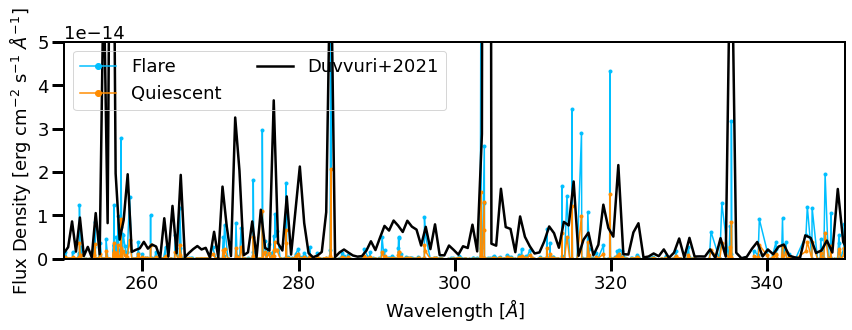

In [35]:
plt.figure(figsize=(14,4))

ster = (units.steradian).to(units.deg**2)

plt.plot(wave_f, 10**(euv_f)/surface_scaling, color='deepskyblue',
        label='Flare', lw=1.5, marker='.')
plt.plot(wave_q, 10**(euv_q)/surface_scaling, color='darkorange',
         label='Quiescent', lw=1.5, marker='.')
plt.plot(duvvuri.time.value, duvvuri.flux.value, label='Duvvuri+2021', 
         color='k', lw=2.5)
plt.legend(ncol=2)
plt.xlim(250,350)
plt.ylim(-1e-16,5e-14)
plt.xlabel('Wavelength [$\AA$]')
plt.ylabel('Flux Density [erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]')
#plt.savefig('/Users/arcticfox/Desktop/dem_attempt2.png', rasterize=True,
#            bbox_inches='tight', dpi=300)

In [42]:
def bin_dem(bins, wave, flux):

    binw, binf = np.array([]), np.array([])
    lowlim, upplim = np.array([]), np.array([])
    
    for i in range(len(bins)-1):
        inds = np.where((wave>=bins[i]) & (wave < bins[i+1]) &
                        (flux>0))[0]
        med = np.nanmean(flux[inds])
        binw = np.append(binw, wave[inds])
        binf = np.append(binf, np.full(len(inds), med))
        lowlim = np.append(lowlim, np.full(len(inds), med-np.nanstd(flux[inds])))
        upplim = np.append(upplim, np.full(len(inds), med+np.nanstd(flux[inds])))
            
    return binw, binf, lowlim, upplim

/Users/arcticfox/opt/anaconda3/lib/python3.9/site-packages/lightkurve/lightcurve.py:223: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  warnings.warn(
No handles with labels found to put in legend.


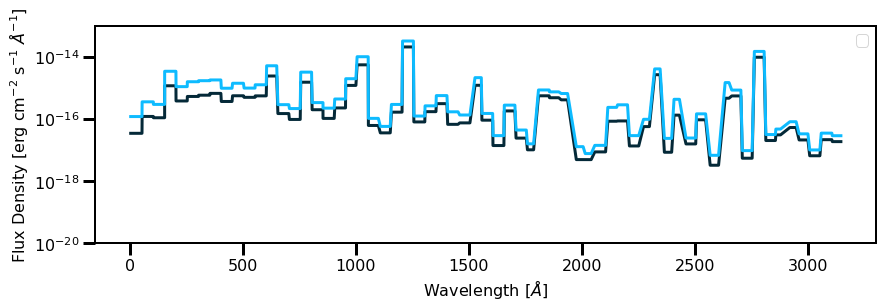

In [39]:
fig = plt.figure(figsize=(14,4))
fig.set_facecolor('w')

binsize=5.0


hdu = fits.open('duvvuri.fits')
duvvuri = LightCurve(hdu[1].data['Wavelength'], 
                     hdu[1].data['Flux_density']).bin(time_bin_size=binsize)
#qq = euv_q>0
#bq = LightCurve(wave_q[qq], 10**(euv_q[qq])/surface_scaling).bin(time_bin_size=binsize)
#qf = euv_f>0
#bf = LightCurve(wave_f[qf], 10**(euv_f[qf])/surface_scaling).bin(time_bin_size=binsize)

binq = bin_dem(bins, wave_q, 10**(euv_q)/surface_scaling)
binf = bin_dem(bins, wave_f, 10**(euv_f)/surface_scaling)

plt.plot(binq[0], binq[1], color='#042938', lw=3)
plt.plot(binf[0], binf[1], color='#0ebbff', lw=3)

#plt.plot(duvvuri.time.value, duvvuri.flux.value, label='Duvvuri+2021', 
#         color='darkorange',zorder=4, lw=3)

#plt.plot(bq.time.value, bq.flux.value, label='Quiescent',lw=2, color='navy')
#plt.plot(bf.time.value, bf.flux.value, label='Flare',lw=2, color='deepskyblue')
plt.xlabel('Wavelength [$\AA$]')
plt.ylabel('Flux Density [erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]')
#plt.xlim(100,400)
plt.ylim(1e-20,1e-13)
plt.legend(ncol=3)
plt.yscale('log')
#plt.savefig('/Users/arcticfox/Desktop/dem_attempt2_zoom.png', rasterize=True,
#            bbox_inches='tight', dpi=300)

# Paper ready plot

In [153]:
hdu = fits.open('duvvuri.fits')
duvvuri = LightCurve(hdu[1].data['Wavelength'], 
                     hdu[1].data['Flux_density'])
duvvuri_table = Table.read('duvvuri_dem.csv', format='csv')

delzanna = Table.read('delzanna.csv', format='csv')

euv_q, euv_f = np.load('dem_spectra.npy', allow_pickle=True)

/Users/arcticfox/opt/anaconda3/lib/python3.9/site-packages/lightkurve/lightcurve.py:223: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  warnings.warn(


In [154]:
def paper_plot(quies, flare, qcolor='k', fcolor=parula[200]):

    fig,ax = plt.subplots(figsize=(14,4))
    for line in list(flare.keys())[:-1]:
        for i, w in enumerate(flare[line]['centers']):
            try:
                plt.errorbar(np.log10(flare[line]['peakFormTemp'][i]), 
                             np.log10(flare[line]['avgDEM'][i]), 
                             yerr=flare[line]['avgDEMErr'][i]/flare[line]['avgDEM'][i]/np.log(10),
                             fmt='o', color=fcolor)
                plt.errorbar(np.log10(quies[line]['peakFormTemp'][i]), 
                             np.log10(quies[line]['avgDEM'][i]), 
                             yerr=quies[line]['avgDEMErr'][i]/quies[line]['avgDEM'][i]/np.log(10),
                             fmt='o', color=qcolor)

            except:
                pass
            
    line, i = 'CI', 0
    plt.errorbar(np.log10(flare[line]['peakFormTemp'][i]), 
                             np.log10(flare[line]['avgDEM'][i]), 
                             yerr=flare[line]['avgDEMErr'][i]/flare[line]['avgDEM'][i],
                             fmt='o', color=fcolor, label='DEMs, Flare')
    
    plt.errorbar(np.log10(quies[line]['peakFormTemp'][i]), 
                 np.log10(quies[line]['avgDEM'][i]), 
                 yerr=quies[line]['avgDEMErr'][i]/quies[line]['avgDEM'][i],
                 fmt='o', color=qcolor, label='DEMs, Quiescent')
            
        
    plt.plot(flare['EUV']['DEMUV']['Chebyshev']['Trange'], 
             flare['EUV']['DEMUV']['Chebyshev']['Fit'][1], 
             lw=4, color=fcolor, zorder=0,
             label='DEM function, Flare')
    
    
    plt.fill_between(x=flare['EUV']['DEMUV']['Chebyshev']['Trange'], 
                     y1=flare['EUV']['DEMUV']['Chebyshev']['Fit'][0], 
                     y2=flare['EUV']['DEMUV']['Chebyshev']['Fit'][2],
                     color=fcolor, alpha=0.3, zorder=3)
    
    plt.fill_between(x=quies['EUV']['DEMUV']['Chebyshev']['Trange'], 
                     y1=quies['EUV']['DEMUV']['Chebyshev']['Fit'][0], 
                     y2=quies['EUV']['DEMUV']['Chebyshev']['Fit'][2],
                     color=qcolor, alpha=0.3, zorder=3)
    
    
    plt.plot(quies['EUV']['DEMUV']['Chebyshev']['Trange'], 
             quies['EUV']['DEMUV']['Chebyshev']['Fit'][1], 
             lw=4, color=qcolor,  zorder=0,
             label='DEM function, Quiescent')
    
    plt.xlabel('log$_{10}$ Temperature [K]')
    plt.ylabel('log$_{10}$ DEM [cm$^{-5}$ K$^{-1}$]')
    plt.ylim(15,28)
    plt.xlim(3.94,8)
    
    return fig,ax

/var/folders/gz/h7_ym7m52dlgq4xpllc1x3m40000gn/T/ipykernel_91182/2024375919.py:40: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('/Users/arcticfox/Documents/AUMic/paper/dem_models.pdf',


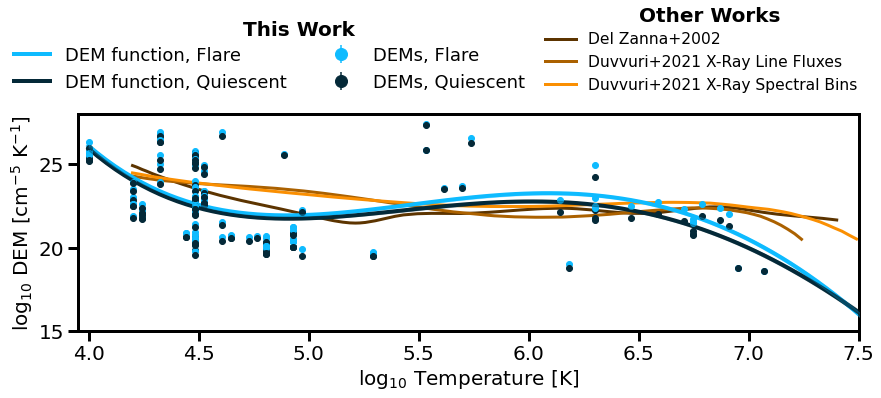

In [156]:
duvvuri_table = Table.read('duvvuri_dem_aumic.csv', format='csv')
interp_lines = interp1d(duvvuri_table['t_line_fluxes'], duvvuri_table['dem_line_fluxes'])
interp_bins  = interp1d(duvvuri_table['t_spectral_bins'], duvvuri_table['dem_spectral_bins'])
interp_zanna = interp1d(delzanna['logT'], delzanna['logDEM'])

x1 = np.linspace(4.17,7.24,500)
x2 = np.linspace(4.20,7.49,500)
x3 = np.linspace(4.20,7.4,500)

fig,ax = paper_plot(dem_q.linelist, dem_f.linelist, 
                    fcolor='#0ebbff', qcolor='#042938')
fig.set_facecolor('w')

x1 = np.linspace(4.17,7.24,100)
x2 = np.linspace(4.20,7.49,100)
twin = ax.twinx()
twin.set_zorder(twin.get_zorder()-1)
twin.plot(x3, interp_zanna(x3), lw=3, color='#5c3400',
          label='Del Zanna+2002', zorder=0)
twin.plot(x1, interp_lines(x1), lw=3, color='#ab6100', 
          label='Duvvuri+2021 X-Ray Line Fluxes',zorder=0)
twin.plot(x2, interp_bins(x2), lw=3, color='#fa8f02', 
          label='Duvvuri+2021 X-Ray Spectral Bins',zorder=0)

twin.set_yticks([])
twin.set_ylim(15,28)


y=32.6
plt.text(s='This Work', x=4.7, y=32.7, fontweight='bold', fontsize=20)
plt.text(s='Other Works', x=6.5, y=33.5, fontweight='bold', fontsize=20)

tlgd = twin.legend(bbox_to_anchor=(0.59, 1.07, 1., .102), loc=3, frameon=False,
                   ncol=1,  borderaxespad=0., fontsize=15.5)#, title='Duvvuri+2021')#, fontweight='bold')
ax.legend(bbox_to_anchor=(-0.09, 1.07, 1., .05), loc=3, frameon=False,
               ncol=2,  borderaxespad=0., fontsize=18)#, title='This Work')
#ax.set_yticks(np.arange(15,35,5))
plt.xlim(3.95,7.5)

plt.savefig('/Users/arcticfox/Documents/AUMic/paper/dem_models.pdf', 
            rasterize=True,
            bbox_inches='tight', dpi=250)